# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Attention, Concatenate
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

# LOAD DATASET

In [ ]:
# Load dataset
data = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [ ]:
# TRAIN AND TEST DATA INFO

In [67]:
print("_____________________________________________________")
print("TRAIN DATA INFO")
data.info()
print("_____________________________________________________")
print("TEST DATA INFO")
test_df.info()
train_class_distribution = data['bias_text'].value_counts().reset_index()
test_class_distribution = test_df['bias_text'].value_counts().reset_index()

# Rename columns for clarity
train_class_distribution.columns = ['Class', 'Train_Count']
test_class_distribution.columns = ['Class', 'Test_Count']

# Merge class distributions for comparison
class_distribution = pd.merge(train_class_distribution, test_class_distribution, on='Class', how='outer').fillna(0)

# Print class distribution
print("\nClass Distribution in Train and Test sets:")
print("________________________________________________________")
print(class_distribution)

# Calculate class distribution in percentages
train_class_distribution = data['bias_text'].value_counts(normalize=True) * 100
test_class_distribution = test_df['bias_text'].value_counts(normalize=True) * 100

# Convert to DataFrame for better readability
distribution_df = pd.DataFrame({
    'Class': train_class_distribution.index,
    'Train_Distribution (%)': train_class_distribution.values,
    'Test_Distribution (%)': test_class_distribution.reindex(train_class_distribution.index, fill_value=0).values
})

# Print class distribution in percentages
print("\nClass Distribution in Train and Test sets (in %):")
print("________________________________________________________")
print(distribution_df)

_____________________________________________________
TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24197 entries, 0 to 24196
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        24197 non-null  int64 
 1   topic             24197 non-null  object
 2   source            24197 non-null  object
 3   bias              24197 non-null  int64 
 4   url               24197 non-null  object
 5   title             24197 non-null  object
 6   date              21972 non-null  object
 7   authors           18572 non-null  object
 8   content           24197 non-null  object
 9   content_original  24197 non-null  object
 10  source_url        24197 non-null  object
 11  bias_text         24197 non-null  object
 12  ID                24197 non-null  object
 13  text              24197 non-null  object
 14  label             24197 non-null  int32 
dtypes: int32(1), int64(2), object(12)


# DATA PREPROCESSING

In [ ]:
data['text'] = data['title'] + " " + data['content_original']
test_df['text'] = test_df['title'] + " " + test_df['content_original']
data['text'] = data['text'].str.lower().fillna("")
test_df['text'] = test_df['text'].str.lower().fillna("")

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['bias_text'])
test_df['label'] = label_encoder.transform(test_df['bias_text'])

# Save label encoder
with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(label_encoder, le_file)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# TOKENIZE TEXT

In [58]:

# Tokenize text
max_words = 30000
#max_words = 20000
max_len = 512
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Save tokenizer
with open("tokenizer.pkl", "wb") as tok_file:
    pickle.dump(tokenizer, tok_file)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)




# EMBEDDING

In [ ]:
# Load GloVe embeddings
embedding_dim = 300
embedding_index = {}
with open("glove.6B.300d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Calculate class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# BUILDING THE MODEL

In [ ]:
# Build the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
concatenated = Concatenate()([GlobalMaxPooling1D()(lstm_layer), GlobalMaxPooling1D()(attention_layer)])
dense_layer = Dense(64, activation="relu")(concatenated)
dropout_layer = Dropout(0.1)(dense_layer)
output_layer = Dense(3, activation="softmax")(dropout_layer)

model = Model(input_layer, output_layer)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


# TRAIN AND EVALUATE THE MODEL

In [59]:

# Train the model
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_val_pad, y_val),
                    epochs=25,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_pad, test_df['label'])
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and evaluation
y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(test_df['label'], y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(test_df['label'], y_test_pred, target_names=label_encoder.classes_))

# Save the model
model.save("news_bias_model-11.h5")
print("Model saved as 'news_bias_model-11.h5'")


Epoch 1/25
605/605 [==============================] - 1891s 3s/step - loss: 0.8147 - accuracy: 0.6038 - val_loss: 0.6236 - val_accuracy: 0.7349
Epoch 2/25
605/605 [==============================] - 2200s 4s/step - loss: 0.5641 - accuracy: 0.7626 - val_loss: 0.5351 - val_accuracy: 0.7822
Epoch 3/25
605/605 [==============================] - 1787s 3s/step - loss: 0.4729 - accuracy: 0.8054 - val_loss: 0.4799 - val_accuracy: 0.8079
Epoch 4/25
605/605 [==============================] - 1765s 3s/step - loss: 0.4093 - accuracy: 0.8340 - val_loss: 0.4817 - val_accuracy: 0.8048
Epoch 5/25
605/605 [==============================] - 1725s 3s/step - loss: 0.3703 - accuracy: 0.8539 - val_loss: 0.4783 - val_accuracy: 0.8128
Epoch 6/25
605/605 [==============================] - 1671s 3s/step - loss: 0.3267 - accuracy: 0.8738 - val_loss: 0.4629 - val_accuracy: 0.8165
Epoch 7/25
605/605 [==============================] - 1688s 3s/step - loss: 0.2829 - accuracy: 0.8925 - val_loss: 0.4733 - val_accuracy:

C:\Users\Dell\anaconda3\envs\task4\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# Function to plot training history
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


"\n# Confusion Matrix and Classification Report\nplot_confusion_matrix(test_df['label'], y_test_pred, label_encoder.classes_)\n\n# Plot training history\nplot_training_history(history)\n\n# Predictions and evaluation\ny_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)\n\n# Plot training history\nplot_training_history(history)\n\n# Plot test accuracy & loss\nplot_test_metrics(test_loss, test_accuracy)\n\n# Predictions and evaluation\ny_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)\n"

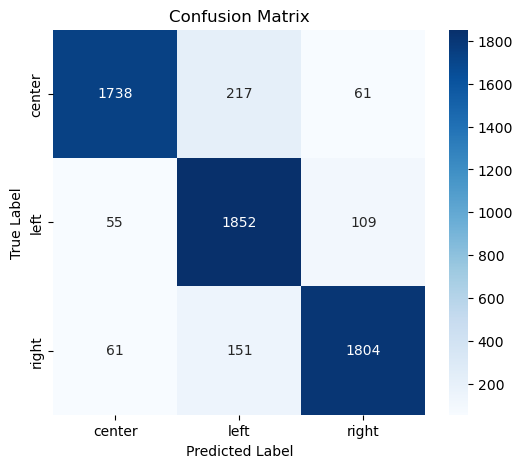

In [62]:
# Confusion Matrix and Classification Report
plot_confusion_matrix(test_df['label'], y_test_pred, label_encoder.classes_)


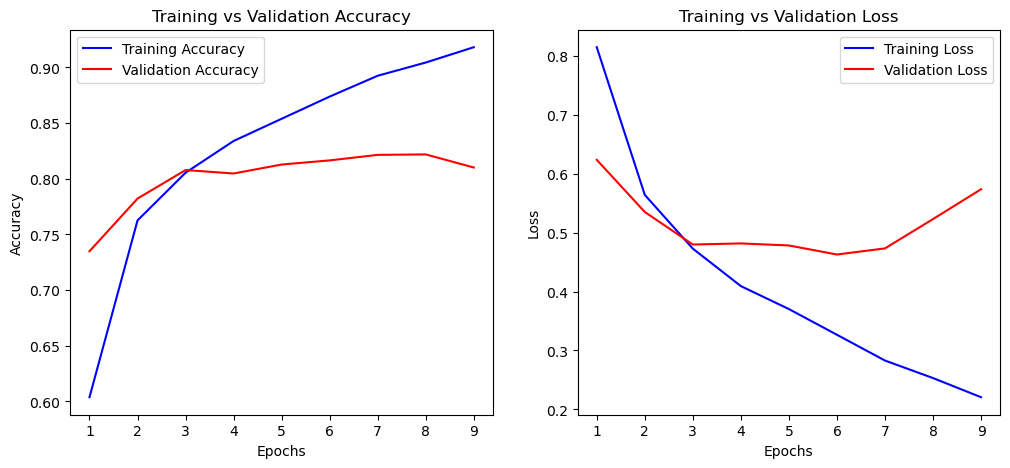

In [63]:
# Plot training history
plot_training_history(history)

In [64]:
# Predictions and evaluation
y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)

189/189 [==============================] - 204s 1s/step


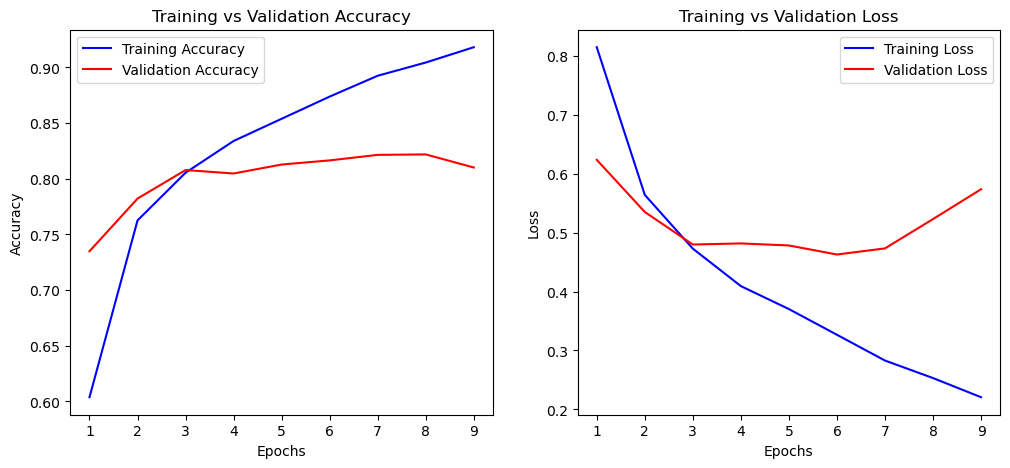

In [65]:
# Plot training history
plot_training_history(history)

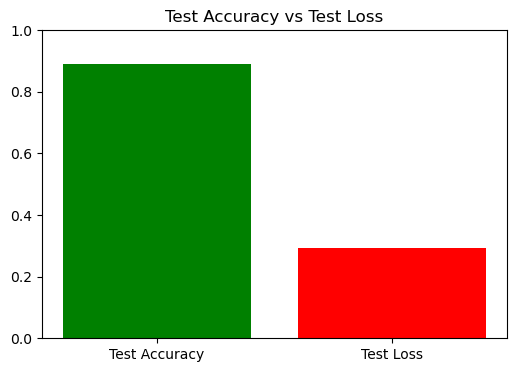

In [66]:
# Plot test accuracy & loss
plot_test_metrics(test_loss, test_accuracy)

# PREDICTING WITH SAMPLE DATA

In [69]:
from tensorflow.keras.models import Sequential, load_model
# Load the model for prediction
loaded_model = load_model("news_bias_model-11.h5")

# Predict on new data
new_texts = ["""In a tweet on Wednesday night , Mr. Trump urged supporters to “ join me ” at a campaign rally scheduled for Aug. 22 in Phoenix . But the Phoenix mayor , Greg Stanton , said in his own tweet that he was “ disappointed ” that the president would hold a political event “ as our nation is still healing from the tragic events in Charlottesville. ” He urged Mr. Trump to delay the visit .
The president ’ s top advisers described themselves as stunned , despondent and numb . Several said they were unable to see how Mr. Trump ’ s presidency would recover , and others expressed doubts about his capacity to do the job .
In contrast , the president told close aides that he felt liberated by his news conference . Aides said he seemed to bask afterward in his remarks , and viewed them as the latest retort to the political establishment that he sees as trying to tame his impulses .
Mr. Trump ’ s venting on Tuesday came despite pleas from his staff , including his daughter Ivanka Trump and her husband , Jared Kushner . Instead of taking their advice to stop talking about the protest , the president eagerly unburdened himself of what he viewed as political correctness in favor of a take-no-prisoners attack on the “ alt-left . ”
On Wednesday , even Fox News , a favorite of the president ’ s , repeatedly carried criticism of Mr. Trump . One Fox host , Shepard Smith , said that he had been unable to find a single Republican to come on-air to defend Mr. Trump ’ s remarks .
No one from the president ’ s team has resigned as of yet , but some spoke candidly on Wednesday about whether they could continue to work much longer for a man who has expressed such sentiments . Most incensed among Mr. Trump ’ s top advisers , according to three people familiar with the situation , was Gary D. Cohn , the director of the National Economic Council , who told people around him that he was offended , as a Jew and as an American , by the president ’ s reaction to the violence in Charlottesville .
The relationship between the president and Mr. Cohn , who stood next to Mr. Trump during the news conference , seems to have suffered a serious blow . Although White House aides denied that he was planning to quit , they acknowledged that Mr. Cohn , a former Goldman Sachs executive , was upset with the president ’ s lack of discipline."""] 


new_sequences = tokenizer.texts_to_sequences(new_texts)
new_pad = pad_sequences(new_sequences, maxlen=max_len)

predictions = np.argmax(loaded_model.predict(new_pad), axis=-1)
predicted_labels = label_encoder.inverse_transform(predictions)

for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Bias: {label}\n")

1/1 [==============================] - 1s 778ms/step
Text: In a tweet on Wednesday night , Mr. Trump urged supporters to “ join me ” at a campaign rally scheduled for Aug. 22 in Phoenix . But the Phoenix mayor , Greg Stanton , said in his own tweet that he was “ disappointed ” that the president would hold a political event “ as our nation is still healing from the tragic events in Charlottesville. ” He urged Mr. Trump to delay the visit .
The president ’ s top advisers described themselves as stunned , despondent and numb . Several said they were unable to see how Mr. Trump ’ s presidency would recover , and others expressed doubts about his capacity to do the job .
In contrast , the president told close aides that he felt liberated by his news conference . Aides said he seemed to bask afterward in his remarks , and viewed them as the latest retort to the political establishment that he sees as trying to tame his impulses .
Mr. Trump ’ s venting on Tuesday came despite pleas from his 